In [58]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from tensorflow.keras.applications.xception import preprocess_input
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
train_set = ImageDataGenerator(rescale=1./255).flow_from_directory('/kaggle/input/dataset3modified/dataset(3) - modified/images/train',
                                              target_size = (48,48),
                                              color_mode = "rgb",
                                              batch_size=128,
                                              class_mode='categorical',
                                              shuffle=True)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory('/kaggle/input/dataset3modified/dataset(3) - modified/images/validation',
                                              target_size = (48,48),
                                              color_mode = "rgb",
                                              batch_size=128,
                                              class_mode='categorical',
                                              shuffle=False)


Found 58454 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [3]:
x_train, y_train = [], []
for i in range(len(train_set)):#batch_size:
    batch = next(train_set)
    x_train.append(batch[0])
    y_train.append(batch[1])

# Concatenate batches to get the final x_train and y_train arrays
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

In [4]:
x_test, y_test = [], []
for i in range(len(test_set)):#batch_size:
    batch = next(test_set)
    x_test.append(batch[0])
    y_test.append(batch[1])

# Concatenate batches to get the final x_train and y_train arrays
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

In [5]:
xception_model = Xception(weights='imagenet', include_top=False)
x = xception_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(512)(x)
xception_model = Model(xception_model.input,output)

83683744/83683744 [==============================] - 0s 0us/step


In [6]:
def extract_xception_features(data):
    features = xception_model.predict(data)
    return features.reshape(features.shape[0], -1)

In [7]:
X_train_features = extract_xception_features(x_train)
X_test_features = extract_xception_features(x_test)

221/221 [==============================] - 2s 8ms/step


# ***Genetic Optimzation***

**Benefits:**
* 1. Can handle complex optimization problems.
* 2. Capable of escaping local optima due to its stochastic nature.
* 3. Flexible and easy to adapt to different kinds of problems.

**Limitations**:
* Computationally intensive, especially for large populations and many generations.
* Performance depends on parameter settings (e.g., population size, mutation rate).
* No guarantee of finding the optimal solution.

In [8]:
def initialize_population(population_size, num_features): #bt2kd ene selected 20 bs
    population = np.zeros((population_size, num_features), dtype=int)
    for i in range(population_size):
        indices = np.random.choice(num_features, 20, replace=False)
        population[i, indices] = 1 #This line sets the value of the selected features to 1
    return population


def evaluate_fitness(population, x_train, y_train, x_test, y_test): #evaluates the "fitness" of each individual in a given population by random forest
    fitness_scores = []
    for individual in population:
        selected_features = x_train[:, individual == 1]
        model = RandomForestClassifier()
        model.fit(selected_features, y_train)
        y_val_pred = model.predict(x_test[:, individual == 1])
        accuracy = accuracy_score(y_test, y_val_pred)
        fitness_scores.append(accuracy)
    return np.array(fitness_scores)

def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1) - 1)

    # Ensure the child has exactly 20 features
    child1_selected = np.sum(parent1[:crossover_point])
    child2_selected = 20 - child1_selected
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    selected_indices = np.where(child1 == 1)[0]
    not_selected_indices = np.where(child1 == 0)[0]
    
    # If more than 20 features are selected, turn off the extras
    if len(selected_indices) > 20:
        turn_off = np.random.choice(selected_indices, size=len(selected_indices) - 20, replace=False)
        child1[turn_off] = 0

    # If less than 20 features are selected, turn on the required number
    elif len(selected_indices) < 20:
        turn_on = np.random.choice(not_selected_indices, size=20 - len(selected_indices), replace=False)
        child1[turn_on] = 1

    return child1

def mutate(individual, mutation_rate): # introduce random changes: A feature that is currently selected its value is 1 randomly chosen to set to 0
    for _ in range(int(len(individual) * mutation_rate)):
        disable = np.random.choice(np.where(individual == 1)[0])
        enable = np.random.choice(np.where(individual == 0)[0])
        individual[disable] = 0
        individual[enable] = 1
    return individual

# Genetic Algorithm
def genetic_algorithm(num_generations, population_size, mutation_rate, X_train, y_train, X_val, y_val):
    num_features = X_train.shape[1]
    population = initialize_population(population_size, num_features)

    for generation in tqdm(range(num_generations)):
        fitness_scores = evaluate_fitness(population, X_train, y_train, X_val, y_val)

        parents_indices = np.argsort(fitness_scores)[-2:] #The two best individuals are selected based on their fitness scores.
        offspring = [population[i] for i in parents_indices]

        for i in range(population_size - 2):
            parent1 = population[np.random.choice(parents_indices)]
            parent2 = population[np.random.choice(parents_indices)]
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            offspring.append(child)

        population = offspring

    best_individual = population[np.argmax(fitness_scores)]
    return best_individual

num_generations = 4
population_size = 3
mutation_rate = 0.1

# Assume X_train_features, y_train, X_test_features, y_test are defined
best_features_mask = genetic_algorithm(num_generations, population_size, mutation_rate, X_train_features, y_train, X_test_features, y_test)
selected_features = X_train_features[:, best_features_mask == 1]

100%|██████████| 4/4 [11:24<00:00, 171.04s/it]


In [63]:
selected_features_test = X_test_features[:, best_features_mask == 1]
print(X_train_features.shape)
print(selected_features.shape)
print(X_test_features.shape)
print(selected_features_test.shape)

(58454, 512)
(58454, 20)
(7066, 512)
(7066, 20)


In [46]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(selected_features, y_train)
predictions = classifier.predict(selected_features_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8229549957543164


In [64]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       960
           1       1.00      0.77      0.87       111
           2       0.99      0.82      0.90      1018
           3       0.99      0.82      0.90      1825
           4       1.00      0.83      0.91      1216
           5       1.00      0.81      0.89      1139
           6       1.00      0.85      0.92       797

   micro avg       0.99      0.82      0.90      7066
   macro avg       1.00      0.82      0.90      7066
weighted avg       0.99      0.82      0.90      7066
 samples avg       0.82      0.82      0.82      7066



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


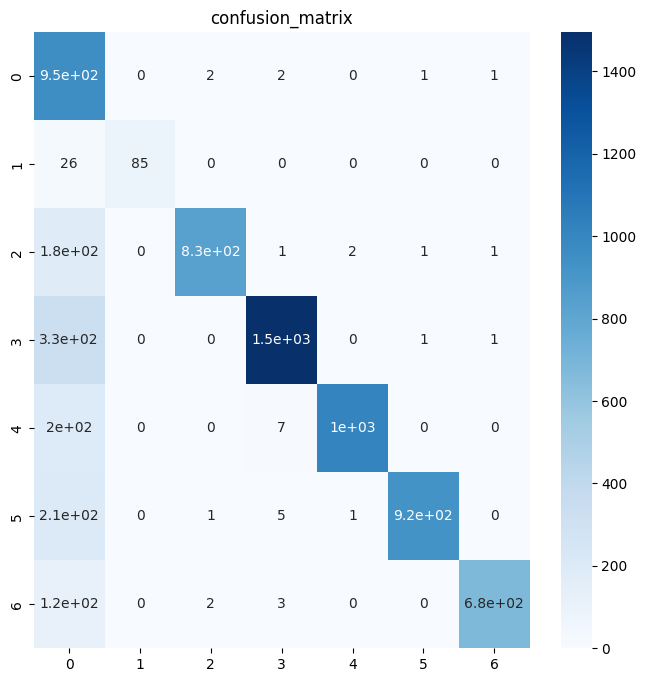

In [65]:
plt.figure (figsize = [8,8])
y_test_labels = np.argmax(y_test, axis=1)
predictions_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test_labels, predictions_labels)
sns.heatmap(cm, annot=True,cmap='Blues')
plt.title("confusion_matrix")
plt.show()